In [52]:
# Imports and Function Initialization

import numpy as np
import math
from math import log2, sqrt
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import Initialize
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram
import scipy.stats
import matplotlib.pyplot as plt
from qiskit.circuit.library import RYGate, CCXGate
from collections import deque
from qiskit_aer import AerSimulator

In [53]:
# Choose CDF for INTEGRABLE distributions, some are given

# NOTE feel free to change the values in the function header

def normal_cdf(x, mean=0.5, std=1/6):
    '''
    Normal Distribution
    '''
    return scipy.stats.norm.cdf(x, mean, std)

def uniform_cdf(x, a=0, b=1):
    '''
    Uniform Distribution
    '''
    if (x < a):
        return 0
    if (x > b):
        return 1
    return (x-a)/(b-a)
    
def exponential_cdf(x, lam=5):
    '''
    Exponential Distribution
    '''
    return scipy.stats.expon.cdf(x, scale=1/lam)

num_qubits = 4 # adjust this
cdf = normal_cdf

In [54]:
num_states = 2**num_qubits
state_step = 1 / num_states

# Gather all values into a list
p = []
for i in range(1, num_states + 1):
    state = i * state_step
    p.append(cdf(state) - cdf(state - state_step))

# Normalize the distribution
p = np.array(p)
p = p / np.sum(p)

print(p)

[0.00299062 0.00791339 0.01822108 0.03650941 0.06365918 0.09659362
 0.12754723 0.14656546 0.14656546 0.12754723 0.09659362 0.06365918
 0.03650941 0.01822108 0.00791339 0.00299062]


\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \qw \barrier[0em]{3} & \qw & \qw & \qw & \qw \barrier[0em]{3} & \qw & \qw \barrier[0em]{3} & \qw & \qw & \qw & \qw \barrier[0em]{3} & \qw & \qw & \qw & \qw \barrier[0em]{3} & \qw & \qw & \qw & \qw \barrier[0em]{3} & \qw & \qw \barrier[0em]{3} & \qw & \qw & \gate{\mathrm{R_Y}\,(\mathrm{2.039})} & \qw \barrier[0em]{3} & \qw & \qw & \gate{\mathrm{R_Y}\,(\mathrm{1.912})} & \qw \barrier[0em]{3} & \qw & \qw & \gate{\mathrm{R_Y}\,(\mathrm{1.778})} & \qw \barrier[0em]{3} & \qw & \qw & \gate{\mathrm{R_Y}\,(\mathrm{1.64})} & \qw \barrier[0em]{3} & \qw & \qw & \gate{\mathrm{R_Y}\,(\mathrm{1.501})} & \qw \barrier[0em]{3} & \qw & \qw & \gate{\mathrm{R_Y}\,(\mathrm{1.364})} & \qw \barrier[0em]{3} & \qw & \qw & \gate{\mathrm{R_Y}\,(\mathrm{1.23})} & \qw \barrier[0em]{3} & \qw & \gate{\mat

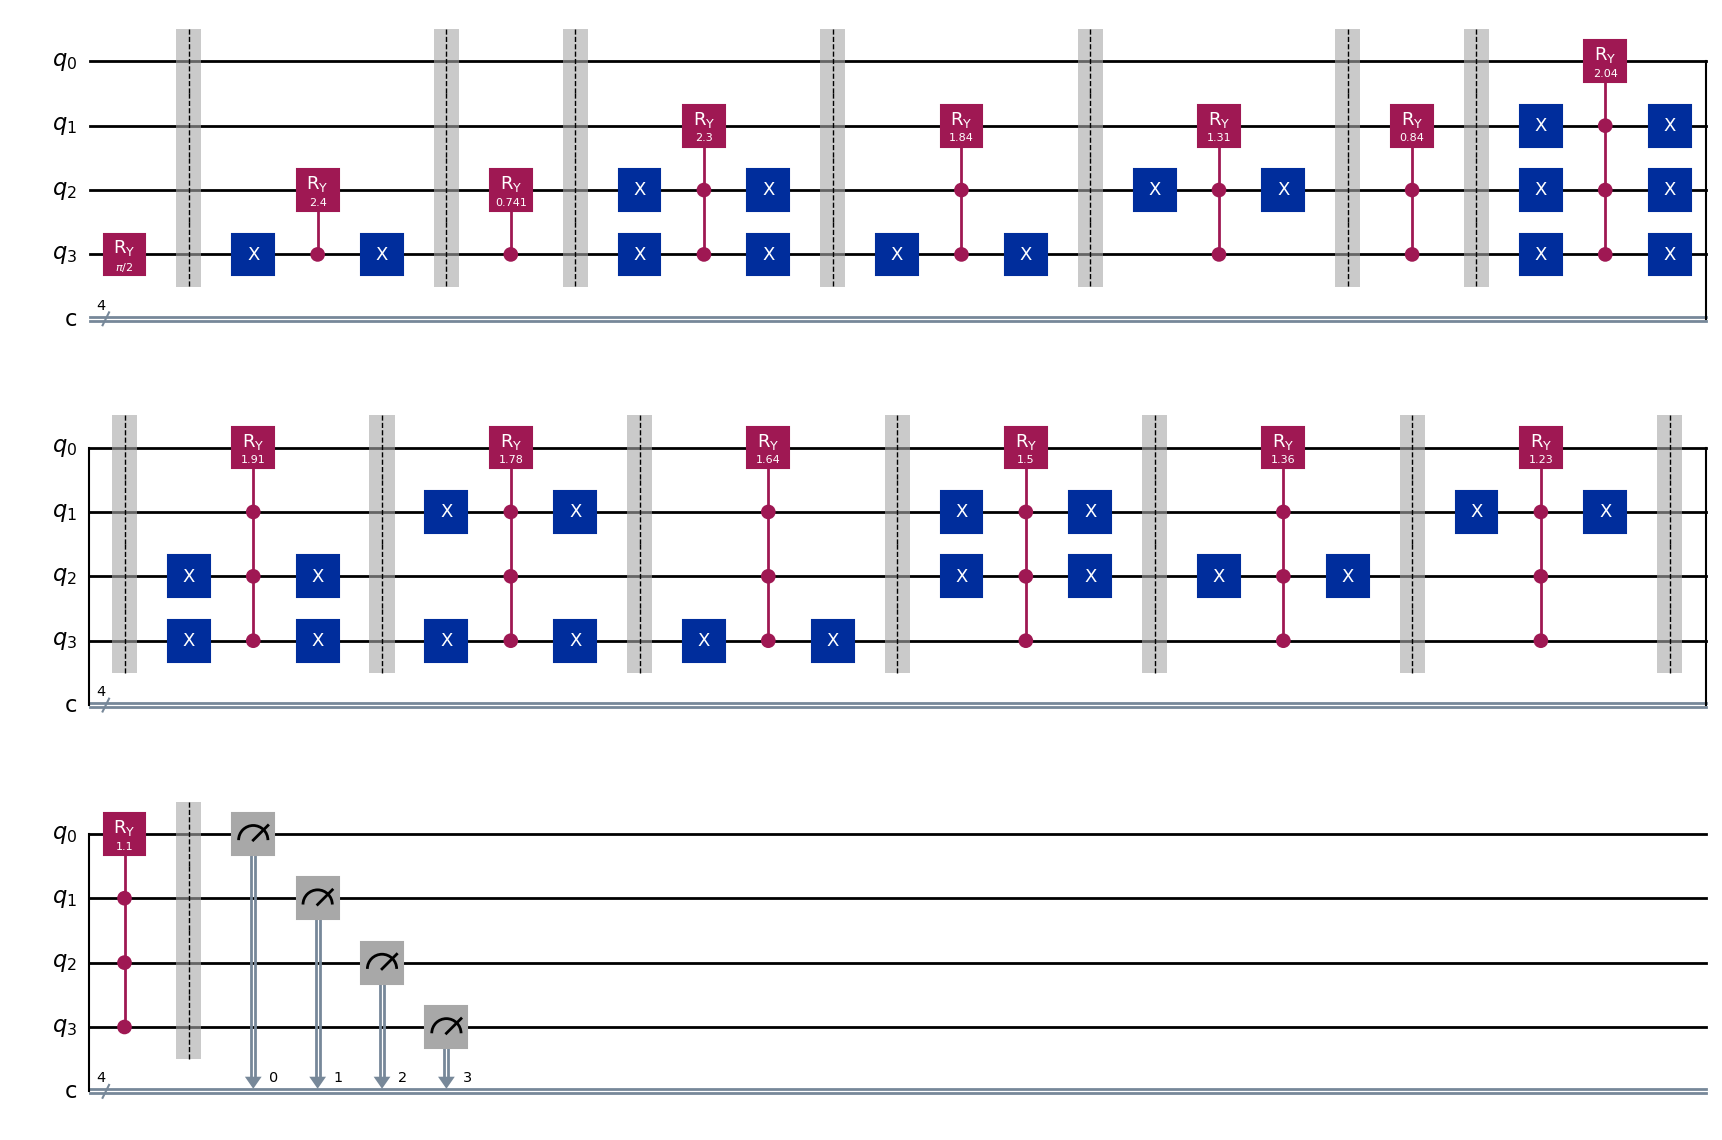

In [55]:
def create_circuit(p):

    qc = QuantumCircuit(num_qubits,num_qubits)

    queue = deque()
    queue.append((p, [], 1))

    while queue:
        curr_p, curr_path, prev_sum = queue.popleft()

        if len(curr_p) == 1:
            continue
        
        mid = len(curr_p) // 2
        left_sum = sum(curr_p[:mid])
        theta = 2 * np.arccos(np.sqrt(left_sum / prev_sum))

        if len(curr_path) == 0:
            qc.ry(theta, num_qubits - 1) 
        else:
            control_qubits = [num_qubits - 1 - i for i in range(len(curr_path))]  
            
            not_gates = []
            for i in range(len(curr_path)):
                if curr_path[i]:
                    not_gates.append(control_qubits[i])

            qc.x(not_gates) if not_gates else None
            qc.append(RYGate(theta).control(len(curr_path)), 
                      control_qubits + [num_qubits - 1 - len(curr_path)])  
            qc.x(not_gates) if not_gates else None

        qc.barrier()
        
        queue.append((curr_p[:mid], curr_path + [True], left_sum))
        queue.append((curr_p[mid:], curr_path + [False], prev_sum - left_sum))
    qc.measure([i for i in range(num_qubits)], [i for i in range(num_qubits)])
    return qc

qc = create_circuit(p)

# NOTE uncomment next line to recieve latex source code
print(qc.draw(output="latex_source")) 

qc.draw('mpl')

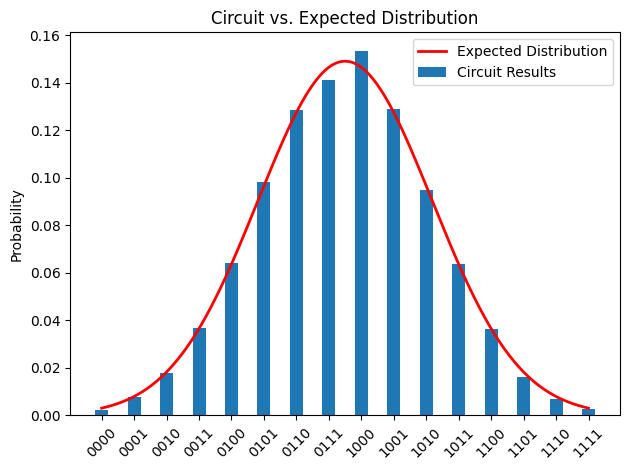

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from scipy.interpolate import make_interp_spline

num_shots = 10000

simulator = AerSimulator()
qc_t = transpile(qc, simulator)
result = simulator.run(qc_t, shots=num_shots).result()
counts = result.get_counts(qc_t)

counts_sorted = [value for key, value in sorted(counts.items())]
counts_normalized = [value / num_shots for value in counts_sorted]

num_states = len(p)
x = np.arange(num_states)

x_smooth = np.linspace(x.min(), x.max(), 300)
spline = make_interp_spline(x, p, k=3)  # Cubic spline
p_smooth = spline(x_smooth)

fig, ax = plt.subplots()
bars1 = ax.bar(x, counts_normalized, width=0.4, label='Circuit Results', align='center')
ax.plot(x_smooth, p_smooth, label='Expected Distribution', color='red', linewidth=2)
ax.set_ylabel('Probability')
ax.set_title('Circuit vs. Expected Distribution')
ax.set_xticks(x)
ax.set_xticklabels([key for key, value in sorted(counts.items())], rotation=45)
ax.legend()
plt.tight_layout()
plt.show()